<a href="https://colab.research.google.com/github/floudata/apuntes/blob/main/Sesion3_Agente_BusquedaInfor_8puzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 3 - Laboratorio


<img src='https://www.danielsaromo.xyz/assets/img/logo-pucp.png' width=200px>


Ing. Daniel Saromo, Dr. Edwin Villanueva

El presente notebook aborda la creación de un agente de busqueda con información para resolver el entorno de juego 8-puzzle (ver figura a continuación).

<font color='orange'>Agente de Búsqueda Con información: Entorno del 8-puzzle</font>

<img src='https://images-na.ssl-images-amazon.com/images/I/61x5wYJJtsL._SX425_.jpg' width=200px>


## Definición del Entorno

### Funciones para conseguir una visualización más didáctica y estilizada

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def convert_maze_toHeatmap(maze_asTupleOfTuples, with_colorbar=True, cmap='jet', fSize=(1, 1)):

    char_list = maze_asTupleOfTuples

    char_to_num = {char: idx for idx, char in enumerate(set(char for sublist in char_list for char in sublist))}

    # Convert the list of lists of characters to a 2D numpy array of numerical values
    num_array = np.array([[char_to_num[char] for char in sublist] for sublist in char_list])

    lista_wallCharacters = ["#"]
    wall_cells = []

    # Plot the heatmap
    plt.figure(figsize=fSize)
    hMap = sns.heatmap(num_array, annot=False, fmt='d', cmap=cmap, cbar=with_colorbar,
                xticklabels=False, yticklabels=False)

    # Optional: Add the original characters as annotations
    for i in range(len(char_list)):
        for j in range(len(char_list[i])):
            plt.text(j + 0.5, i + 0.5, char_list[i][j],
                    ha='center', va='center', color='black')

            if char_list[i][j] in lista_wallCharacters: wall_cells.append((i,j))

    plt.show()

    return num_array

### Clase <b>Thing</b>

  Esta clase generica representa cualquier objeto fisico que puede aparecer en un <b>Ambiente</b>. (No editar)  

In [ ]:
class Thing(object):
    def is_alive(self):
        """Cosas 'vivas'deben retornar true."""
        return hasattr(self, 'alive') and self.alive

    def show_state(self):
        """Muestra el estado interno del agente. Subclases deben sobreescribir esto."""
        print("I don't know how to show_state.")

### Clase <b>Environment</b>

Esta clase abstracta representa un entorno de tareas. Clases de entornos reales heredan de esta. En un entorno tipicamente se necesitará implementar 2 cosas:
<b>percept</b>, que define la percepción que el agente ve; y
<b>execute_action</b>, que define los efectos de ejecutar una acción.
El entorno mantiene una lista de .things y .agents (el cual es un subconjunto de .things). Cada elemento de .things tiene un slot .location. (No editar)

In [ ]:
class Environment(object):

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Retorna la percepcion que el agente 'agent' ve en este punto."""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """El agente 'agent' ejecuta una accion 'action' en el entorno."""
        raise NotImplementedError

    def default_location(self, thing):
        """Localización por defecto para colocar una nueva cosa sin localizacion especificada."""
        return None

    def is_done(self):
        """Retorna True si no hay ningun agente vivo"""
        return not any(agent.is_alive() for agent in self.agents)

    def add_thing(self, thing, location=None):
        """Añade una cosa thing al entorno en la localizacion location.
           Si thing es un programa de agente, crea un nuevo agente con ese programa."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert thing not in self.things, "No permite añadir la misma cosa dos veces"
        thing.location = location if location is not None else self.default_location(thing)
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)

    def step(self, verbose=False):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, obtiene sus acciones y las ejecuta). """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                if action == "None": return None
                #if verbose: print("Voy a ejecutar la acción", action)
                self.execute_action(agent, action)
                #_ = self.convert_maze_toHeatmap(self.status, with_colorbar=False)

    def run(self, steps=1000, verbose=True):
        """Ejecuta steps pasos en el entorno."""
        for step in range(steps):
            if self.is_done():
                return
            self.step(verbose)

### Clase <b>EightpuzzleEnvironment </b>

En esta clase se implementa el entorno del 8-puzzle. Un agente en este entorno percibe el estado del entorno como una tupla de tuplas de 9 numeros, siendo el numero 0 la posicion vacia. Para la Figura de arriba el estado es: ((1,2,3),(4,5,6),(7,8,0))   

In [ ]:
import numpy as np
from copy import deepcopy

class EightpuzzleEnvironment(Environment):

    def __init__(self, initial_state, convert_maze_toHeatmap=convert_maze_toHeatmap):
        super().__init__()
        self.status = initial_state
        self.convert_maze_toHeatmap = convert_maze_toHeatmap

    def thing_classes(self):
        return [EightpuzzleReflexAgent]

    def percept(self, agent):
        """Retorna el estado del ambiente (las piezas que estan en cada posicion)"""
        return self.status

    def add_thing(self, thing, location=None):
        """Añade una cosa thing al entorno en la localizacion location.
           Si thing es un programa de agente, crea un nuevo agente con ese programa.
           En el entorno del 8-puzzle, está PROHIBIDO tener más de un agente en el entorno."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert len(self.things)==0, "Solo permite añadir una única cosa (agente, en este caso) al entorno"
        thing.location = location if location is not None else self.default_location(thing)
        assert isinstance(thing, Agent), "Solo se permite añadir un Agente al entorno 8-puzzle"
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)

    def execute_action(self, agent, action):
        """Implementa el MAPA De TRANSICION: Cambia la posicion de las piezas de acuerdo a la accion solicitada del blanco;
        Cada accion valida debe provocar una disminución de desempeño en 1 unidad """
        state = np.array(self.status)  # convierte el estado del entorno (tuple inmutable) en un array numpy para manipulacion

        tmp = np.where(state == 0)   # obtiene las coordenadas del casillero en blanco (0)
        i_blank = tmp[0][0]   # fila donde esta el blanco
        j_blank = tmp[1][0]   # columna donde esta el blanco

        new_state = deepcopy(state)   # copia state en nueva variable newState

        if action == 'Right':
            if j_blank < (state.shape[1]-1):
                new_state[i_blank,j_blank], new_state[i_blank,j_blank+1] = state[i_blank,j_blank+1], state[i_blank,j_blank]
                agent.performance -= 1
        elif action == 'Left':
            if j_blank > 0:
                new_state[i_blank,j_blank], new_state[i_blank,j_blank-1] = state[i_blank,j_blank-1], state[i_blank,j_blank]
                agent.performance -= 1
        elif action == 'Up':
            if i_blank > 0:
                new_state[i_blank-1,j_blank], new_state[i_blank,j_blank] = state[i_blank,j_blank], state[i_blank-1,j_blank]
                agent.performance -= 1
        elif action == 'Down':
            if i_blank < (state.shape[1]-1):
                new_state[i_blank+1,j_blank], new_state[i_blank,j_blank] = state[i_blank,j_blank], state[i_blank+1,j_blank]
                agent.performance -= 1

        self.status = tuple(map(tuple, new_state))   # actualiza el estado ( como tupla de tuplas)

    def step(self, verbose=False):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, obtiene sus acciones y las ejecuta). """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                if action == "None": return None
                if verbose: print("Voy a ejecutar la acción", action)
                self.execute_action(agent, action)
                _ = self.convert_maze_toHeatmap(self.status, with_colorbar=False)

## Definiciones de Problema de Búsqueda  y Algoritmos de busqueda ciega

### Clase <b>SearchProblem</b>

Esta es una clase abstracta para definir problemas de busqueda. Se debe hacer subclases que implementen los metodos de las acciones, resultados, test de objetivo y el costo de camino. Entonces se puede instanciar las subclases y resolverlos con varias funciones de busqueda.

In [ ]:
class SearchProblem(object):
    def __init__(self, initial, goal=None):
        """Este constructor especifica el estado inicial y posiblemente el estado(s) objetivo(s),
        La subclase puede añadir mas argumentos."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Retorna las acciones que pueden ser ejecutadas en el estado dado.
        El resultado es tipicamente una lista."""
        raise NotImplementedError

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion dada en el estado state.
        La accion debe ser alguna de self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Retorna True si el estado pasado satisface el objetivo."""
        raise NotImplementedError

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con
        la accion action, asumiendo un costo c para llegar hasta state1.
        El metodo por defecto cuesta 1 para cada paso en el camino."""
        return c + 1

### <b> Clase EightpuzzleSearchProblem</b>  
Esta es una subclase de SearchProblem donde se definira concretamente el problema de busqueda para el ambiente del 8-puzzle. Se necesita completar Actions (acciones disponibles para un estado dado) y result (que estado resulta de ejecutar una accion en un estado)

In [ ]:
class EightpuzzleSearchProblem(SearchProblem):

    def __init__(self, initial, goal):
        """El constructor recibe  el estado inicial y el estado objetivo"""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Retorna las acciones ejecutables desde el estado state.
        Por ejemplo, para el estado ((0,1,2),(3,4,5),(6,7,8)) debe retornar: acciones = ['Down', 'Right']"""
        state = np.array(state)   # convierte el state (tuple inmutable) a un array numpy para manipulacion

        acciones = []
        tmp = np.where(state == 0)   # obtiene las coordenadas del casillero en blanco (0)
        i_blank = tmp[0][0]   # fila donde esta el blanco
        j_blank = tmp[1][0]   # columna donde esta el blanco

        if j_blank < (state.shape[1]-1):
            acciones.append('Right')
        if j_blank > 0:
            acciones.append('Left')
        if i_blank > 0:
            acciones.append('Up')
        if i_blank < (state.shape[1]-1):
            acciones.append('Down')

        return acciones

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion action desde state.
        La accion debe ser alguna de self.actions(state)
        Por ejemplo, para state=((0,1,2),(3,4,5),(6,7,8)) y action='Right' debe retornar newState=((0,1,2),(3,4,5),(6,7,8)) """
        state = np.array(state)   # convierte el state (tuple inmutable) a un array numpy para manipulacion

        tmp = np.where(state == 0)   # obtiene las coordenadas del casillero en blanco (0)
        i_blank = tmp[0][0]   # fila donde esta el blanco
        j_blank = tmp[1][0]   # columna donde esta el blanco

        new_state = deepcopy(state)   # copia state en variable newState

        if action == 'Right':
            if j_blank < (state.shape[1]-1):
                new_state[i_blank,j_blank], new_state[i_blank,j_blank+1] = state[i_blank,j_blank+1], state[i_blank,j_blank]

        elif action == 'Left':
            if j_blank > 0:
                new_state[i_blank,j_blank], new_state[i_blank,j_blank-1] = state[i_blank,j_blank-1], state[i_blank,j_blank]

        elif action == 'Up':
            if i_blank > 0:
                new_state[i_blank-1,j_blank], new_state[i_blank,j_blank] = state[i_blank,j_blank], state[i_blank-1,j_blank]

        elif action == 'Down':
            if i_blank < (state.shape[1]-1):
                new_state[i_blank+1,j_blank], new_state[i_blank,j_blank] = state[i_blank,j_blank], state[i_blank+1,j_blank]

        return tuple(map(tuple, new_state))   # el estado retornado es una tupla

    def goal_test(self, state):
        """Retorna True si state es self.goal"""
        return (self.goal == state)

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con la accion action
        El costo del camino para llegar a state1 es c. El costo de la accion es = 1"""
        return c + 1;

In [ ]:
class EightpuzzleSearchProblem(SearchProblem):

    def __init__(self, initial, goal):
        """El constructor recibe  el estado inicial y el estado objetivo"""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Retorna las acciones ejecutables desde el estado state.
        Por ejemplo, para el estado ((0,1,2),(3,4,5),(6,7,8)) debe retornar: acciones = ['Down', 'Right']"""
        state = np.array(state)   # convierte el state (tuple inmutable) a un array numpy para manipulacion

        acciones = []
        tmp = np.where(state == 0)   # obtiene las coordenadas del casillero en blanco (0)
        i_blank = tmp[0][0]   # fila donde esta el blanco
        j_blank = tmp[1][0]   # columna donde esta el blanco

        if j_blank < (state.shape[1]-1):
            acciones.append('Right')
        if j_blank > 0:
            acciones.append('Left')
        if i_blank > 0:
            acciones.append('Up')
        if i_blank < (state.shape[1]-1):
            acciones.append('Down')

        return acciones

    def result(self, state, action):
        """Retorna el estado que resulta de ejecutar la accion action desde state.
        La accion debe ser alguna de self.actions(state)
        Por ejemplo, para state=((0,1,2),(3,4,5),(6,7,8)) y action='Right' debe retornar newState=((0,1,2),(3,4,5),(6,7,8)) """
        state = np.array(state)   # convierte el state (tuple inmutable) a un array numpy para manipulacion

        tmp = np.where(state == 0)   # obtiene las coordenadas del casillero en blanco (0)
        i_blank = tmp[0][0]   # fila donde esta el blanco
        j_blank = tmp[1][0]   # columna donde esta el blanco

        new_state = deepcopy(state)   # copia state en variable newState

        if action == 'Up':
            if i_blank > 0:
                new_state[i_blank-1,j_blank], new_state[i_blank,j_blank] = state[i_blank,j_blank], state[i_blank-1,j_blank]

        elif action == 'Down':
            if i_blank < (state.shape[1]-1):
                new_state[i_blank+1,j_blank], new_state[i_blank,j_blank] = state[i_blank,j_blank], state[i_blank+1,j_blank]

        elif action == 'Right':
            if j_blank < (state.shape[1]-1):
                new_state[i_blank,j_blank], new_state[i_blank,j_blank+1] = state[i_blank,j_blank+1], state[i_blank,j_blank]

        elif action == 'Left':
            if j_blank > 0:
                new_state[i_blank,j_blank], new_state[i_blank,j_blank-1] = state[i_blank,j_blank-1], state[i_blank,j_blank]

        return tuple(map(tuple, new_state))   # el estado retornado es una tupla

    def goal_test(self, state):
        """Retorna True si state es self.goal"""
        return (self.goal == state)

    def path_cost(self, c, state1, action, state2):
        """Retorna el costo del camino de state2 viniendo de state1 con la accion action
        El costo del camino para llegar a state1 es c. El costo de la accion es = 1"""
        return c + 1;

### Clase <b>Node</b>

Estructura de datos para almacenar la informacion de un nodo en un <b>arbol de busqueda</b>. Contiene información del nodo padre y el estado que representa el nodo. Tambien incluye la accion que nos llevo al presente nodo y el costo total del camino desde el nodo raiz hasta este nodo.

In [ ]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        "Crea un nodo de arbol de busqueda, derivado del nodo parent y accion action"
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def expand(self, problem):
        "Devuelve los nodos alcanzables en un paso a partir de este nodo."
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

        #milista = []
        #for action in problem.actions(self.state)
        #    milista.append(self.child_node(problem, action))

    def child_node(self, problem, action):
        next = problem.result(self.state, action)
        return Node(next, self, action,
                    problem.path_cost(self.path_cost, self.state, action, next))

    def solution(self):
        "Retorna la secuencia de acciones para ir de la raiz a este nodo."
        return [node.action for node in self.path()[1:]]

    def path(self):
        "Retorna una lista de nodos formando un camino de la raiz a este nodo."
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __lt__(self, node):
        return self.state < node.state

    def __eq__(self, other):
        "Este metodo se ejecuta cuando se compara nodos. Devuelve True cuando los estados son iguales"
        return isinstance(other, Node) and self.state == other.state

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __hash__(self):
        return hash(self.state)

### <b> Define una cola tipo FIFO First-In-First-Out (para BFS)</b>

In [ ]:
from collections import deque

class FIFOQueue(deque):
    """Una cola First-In-First-Out"""
    def pop(self):
        return self.popleft()

### <b>Algoritmo general de búsqueda con memoria de nodos expandidos (Graph Search)</b>

Algoritmo de general de busqueda ciega con memoria de estados visitados. El argumento frontier debe ser una cola vacia. Si  frontier es tipo FIFO hace busqueda en amplitud (BFS), si la frontier es una pila hará busqueda en profundidad (DFS). Devuelve el nodo solucion y una lista de nodos visitados durante la busqueda.

In [ ]:
def graph_search(problem, frontier):
    frontier.append(Node(problem.initial))
    explored = set()     # memoria de estados visitados
    visited_nodes = []   # almacena nodos visitados durante la busqueda
    while frontier:
        node = frontier.pop()
        visited_nodes.append(node)
        if problem.goal_test(node.state):
            return node, visited_nodes
        explored.add(node.state)

        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
    return None

### <b> Frontera tipo cola de prioridad ordenada por una funcion de costo (para best_first_graph_search y A*)</b>

In [ ]:
import heapq
class FrontierPQ:
    "Una Frontera ordenada por una funcion de costo (Priority Queue)"

    def __init__(self, initial, costfn=lambda node: node.path_cost):
        "Inicializa la Frontera con un nodo inicial y una funcion de costo especificada (por defecto es el costo de camino)."
        self.heap   = []
        self.states = {}
        self.costfn = costfn
        self.add(initial)

    def add(self, node):
        "Agrega un nodo a la frontera."
        cost = self.costfn(node)
        heapq.heappush(self.heap, (cost, node))
        self.states[node.state] = node

    def pop(self):
        "Remueve y retorna el nodo con minimo costo."
        (cost, node) = heapq.heappop(self.heap)
        self.states.pop(node.state, None) # remove state
        return node

    def replace(self, node):
        "node reemplaza al nodo de la Fontera que tiene el mismo estado que node."
        if node.state not in self:
            raise ValueError('{} no tiene nada que reemplazar'.format(node.state))
        for (i, (cost, old_node)) in enumerate(self.heap):
            if old_node.state == node.state:
                self.heap[i] = (self.costfn(node), node)
                heapq._siftdown(self.heap, 0, i)
                return

    def __contains__(self, state): return state in self.states

    def __len__(self): return len(self.heap)

### <b> Algoritmo Best-First-Graph-Search </b>
Algoritmo general de busqueda con información. La frontera es una cola de prioridad ordenada por la funcion de evaluacion f

In [ ]:
def best_first_graph_search(problem, f):
    """Busca el objetivo expandiendo el nodo de la frontera con el menor valor de la funcion f. Memoriza estados visitados
    Antes de llamar a este algoritmo hay que especificar La funcion f(node). Si f es node.depth tenemos Busqueda en Amplitud;
    si f es node.path_cost tenemos Busqueda  de Costo Uniforme. Si f es una heurística tenemos Busqueda Voraz;
    Si f es node.path_cost + heuristica(node) tenemos A* """

    frontier = FrontierPQ( Node(problem.initial), f )  # frontera tipo cola de prioridad ordenada por f
    explored = set()     # memoria de estados visitados
    visited_nodes = []   # almacena nodos visitados durante la busqueda
    while frontier:
        node = frontier.pop()
        visited_nodes.append(node)
        if problem.goal_test(node.state):
            return node, visited_nodes
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            if child.state not in explored and child.state not in frontier:
                frontier.add(child)
            elif child.state in frontier:
                incumbent = frontier.states[child.state]
                if f(child) < f(incumbent):
                    frontier.replace(child)

### <b> Algoritmo A* </b>
A* es un caso especial de best_first_graph_search con f = path_cost + heuristic

In [ ]:
def astar_search(problem, heuristic):
    f = lambda node: node.path_cost + heuristic(node, problem)
    return best_first_graph_search(problem, f)

def nullheuristic(node, problem):
    return 0

### Algoritmo de Búsqueda Voraz

In [ ]:
# @title FUNCIÓN PARA BÚSQUEDA VORAZ (GREEDY SEARCH)

def greedy_search(problem, heuristic):
    f = lambda node: 0 + heuristic(node, problem)
    return best_first_graph_search(problem, f)

## <b> Heurísticas para A* </b>
Se debe implementar las heurísticas abajo para A*

In [ ]:
#Para elevar un número a una potencia, se puede usar la libreria math
import math
math.pow(4,2)

16.0

In [ ]:
def locate_element(tuples, element):
    for i, subtuple in enumerate(tuples):
        for j, item in enumerate(subtuple):
            if item == element:
                return (i,j)

In [ ]:
# @title Heurísticas: h1, h2, y h_dominante
import math
def h1(node, problem):
    "Número de piezas fuera de posición"
    tuple1, tuple2 = node.state, problem.goal
    if len(tuple1) != len(tuple2):
        raise ValueError("Tuples must be of the same length")

    count = 0
    for subtuple1, subtuple2 in zip(tuple1, tuple2):
        if len(subtuple1) != len(subtuple2):
            raise ValueError("All sub-tuples must be of the same length")
        for item1, item2 in zip(subtuple1, subtuple2):
            if item1 != item2:
                count += 1
    return count

def h2(node, problem):
    """Distancia Manhatan total: Para cada pieza, calcular la distancia en
    movidas horizontales y verticales hacia su posición objetivo"""
    tuple1, tuple2 = node.state, problem.goal

    if len(tuple1) != len(tuple2):
            raise ValueError("Tuples must be of the same length")

    total_distance = 0

    for i, subtuple in enumerate(tuple1):
        for j, element in enumerate(subtuple):
            pos_atGrid1 = (i, j)
            pos_atGrid2 = locate_element(tuple2, element)

            delta_x = pos_atGrid1[0] - pos_atGrid2[0]
            delta_y = pos_atGrid1[1] - pos_atGrid2[1]
            total_distance +=  abs(delta_x) + abs(delta_y)

    return total_distance

def h_dominante(node, problem):
    "Heurística que domina a las heurísticas cuantificadas por las distancias `straightline_dist` y `manhatan_dist`."
    return max(  h1(node, problem)  ,  h2(node, problem)  )

#### Heurística H weighted

In [ ]:
def h_weighted(node, problem, W=5, h_base = h1):
    # pongo straightline_dist en lugar de manh, porque
    # en este entorno eucl explora más nodos, y se ve más el efecto de usar W
    "Heurística que domina a las heurísticas cuantificadas por las distancias `straightline_dist` y `manhatan_dist`."
    return W * h_base(node, problem)

## Definicion del Agente de Busqueda en el entorno 8-puzzle


### Clase <b>Agent</b>

Un agente es una subclase de Thing con un slot obligatorio: <b>.program</b>, el cual almacena la funcion que implementa el <b>programa del agente</b>. Esta funcion debe tomar como argumento la <b>percepcion</b> del agente y debe retornar una <b>accion</b>. La definicion de Percepcion y Accion depende del ambiente de trabajo (environment) donde el agente existe. El agente tambien puede tener el slot <b>.performance</b>, que guarda el desempeño del agente en su ambiente (desempeño visto desde el agente).

In [ ]:
import collections
#import collections.abc as collections
collections.Iterable = collections.abc.Iterable
collections.Callable = collections.abc.Callable
collections.Sequence = collections.abc.Sequence

class Agent(Thing):

    def __init__(self, program=None):
        self.alive = True
        self.performance = 0
        assert isinstance(program, collections.Callable)
        self.program = program

In [ ]:
import random

## <b> Experimentación con los algoritmos de Busqueda</b>


In [ ]:
"""Crea el entorno del 8-puzzle con estado inicial '' """
initial =  ((3,1,2),(6,4,5),(7,8,0))
goal    =  ((0,1,2),(3,4,5),(6,7,8))
e = EightpuzzleEnvironment(initial)

In [ ]:
p = EightpuzzleSearchProblem(initial, goal)

In [ ]:
e.status

((3, 1, 2), (6, 4, 5), (7, 8, 0))

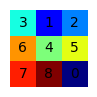

In [ ]:
_ = convert_maze_toHeatmap(e.status, with_colorbar=False)

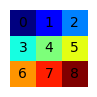

In [ ]:
_ = convert_maze_toHeatmap(goal, with_colorbar=False)

In [ ]:
initial, goal

(((3, 1, 2), (6, 4, 5), (7, 8, 0)), ((0, 1, 2), (3, 4, 5), (6, 7, 8)))

### <b>Clase que implementa el programa del agente que busca y ejecuta soluciones en el entorno 8-puzzle</b>


In [ ]:
class EightpuzzleSearchProgram:
    def __init__(self, goal_state, search_method, convert_maze_toHeatmap=convert_maze_toHeatmap,
                          h1=h1, h2=h2, h_dominante=h_dominante, h_weighted=h_weighted):
        self.goal = goal_state
        self.method = search_method
        self.seq = []  # lista de acciones a ejecutar, inicialmente vacia

        self.h1 = h1
        self.h2 = h2
        self.h_dominante = h_dominante
        self.h_weighted = h_weighted

    def __call__(self, percept):
        state = percept
        if state == self.goal:    # Si el ambiente esta en el estado objetivo no hace nada
            return 'None'
        if not self.seq:  # si la lista de acciones esta vacia
            print('Agente buscara solucion al 8-puzzle')
            print()
            print('- Estado_inicial = {}'.format(state))
            _ = convert_maze_toHeatmap(state, with_colorbar=False)
            print('- Estado_objetivo={}'.format(self.goal))
            _ = convert_maze_toHeatmap(self.goal, with_colorbar=False)
            print("---"*10)
            search_problem = EightpuzzleSearchProblem(state, self.goal)
            if self.method == 'bfs':
                goal_node, visited_nodes = graph_search(search_problem, FIFOQueue()) # frontera es una cola FIFO
            elif self.method == 'dfs':
                goal_node, visited_nodes = graph_search(search_problem, []) # frontera es una pila ([] es una pila en Python)
            elif self.method == 'ucs':
                goal_node, visited_nodes = astar_search(search_problem, nullheuristic) # UCS = A* con heuristica nula

            elif self.method == 'greedy+h1':
                goal_node, visited_nodes = greedy_search(search_problem, self.h1)
            elif self.method == 'greedy+h2':
                goal_node, visited_nodes = greedy_search(search_problem, self.h2)

            elif self.method == 'Astar+h1':
                goal_node, visited_nodes = astar_search(search_problem, self.h1)
            elif self.method == 'Astar+h2':
                goal_node, visited_nodes = astar_search(search_problem, self.h2)

            elif self.method == 'Astar+hdom':
                goal_node, visited_nodes = astar_search(search_problem, self.h_dominante)
            elif self.method == 'Astar+hwei':
                goal_node, visited_nodes = astar_search(search_problem, self.h_weighted)

            elif self.method == 'IDAstar+h1':
                goal_node, visited_nodes = iterative_deepening_astar_search(search_problem, self.h1)
            elif self.method == 'IDAstar+h2':
                goal_node, visited_nodes = iterative_deepening_astar_search(search_problem, self.h2)
            elif self.method == 'IDAstar+hwei':
                goal_node, visited_nodes = iterative_deepening_astar_search(search_problem, self.h_weighted)

            if goal_node == None: # sin solucion
                print('No se encontro solucion para el 8-puzzle con metodo {}'.format(self.method) )
                return 'None'

            self.seq = goal_node.solution()
            print('Agente planeó una solucion al 8-puzzle con {}'.format(self.method))

            print('Seq = {}'.format(self.seq))

            print('Nodos visitados={}. Costo Solucion = {}'.format(len(visited_nodes),goal_node.path_cost))

        action = self.seq.pop(0)
        return action

### Probando el entorno 8-puzzle y agente de búsqueda

In [ ]:
def convert_tuple(input_tuple):
    # Calculate the value of n
    n = int(len(input_tuple) ** 0.5)

    # Check if the length of the tuple is a perfect square
    if n * n != len(input_tuple):
        raise ValueError("The length of the input tuple must be a perfect square.")

    # Create n tuples of n elements each
    result = tuple(input_tuple[i * n:(i + 1) * n] for i in range(n))

    return result

In [ ]:
"""Crea el entorno del 8-puzzle con estado inicial '' """
initial =  convert_tuple((3,1,2,6,4,5,7,8,0))
goal    =  ((0,1,2),(3,4,5),(6,7,8))

#### busqueda en amplitud (BFS)

In [ ]:
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'bfs') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


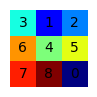

- Estado_objetivo=((0, 1, 2), (3, 4, 5), (6, 7, 8))


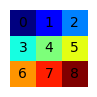

------------------------------
Agente planeó una solucion al 8-puzzle con bfs
Seq = ['Left', 'Left', 'Up', 'Up']
Nodos visitados=17. Costo Solucion = 4
Voy a ejecutar la acción Left


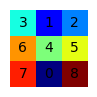

Voy a ejecutar la acción Left


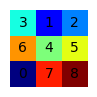

Voy a ejecutar la acción Up


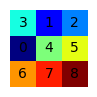

Voy a ejecutar la acción Up


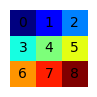

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

In [ ]:
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h2') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


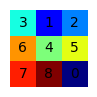

- Estado_objetivo=((0, 1, 2), (3, 4, 5), (6, 7, 8))


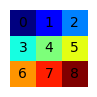

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h2
Seq = ['Left', 'Left', 'Up', 'Up']
Nodos visitados=5. Costo Solucion = 4
Voy a ejecutar la acción Left


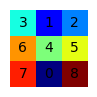

Voy a ejecutar la acción Left


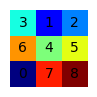

Voy a ejecutar la acción Up


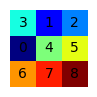

Voy a ejecutar la acción Up


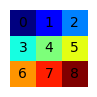

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

#### busqueda A* con heurística h1

In [ ]:
"""Inicializamos el entorno"""
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h1') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


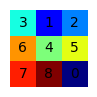

- Estado_objetivo=((0, 1, 2), (3, 4, 5), (6, 7, 8))


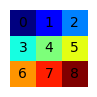

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h1
Seq = ['Left', 'Left', 'Up', 'Up']
Nodos visitados=5. Costo Solucion = 4
Voy a ejecutar la acción Left


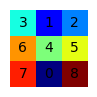

Voy a ejecutar la acción Left


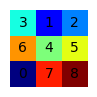

Voy a ejecutar la acción Up


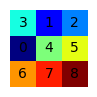

Voy a ejecutar la acción Up


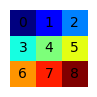

In [ ]:
# Ejecuta el entorno 25 pasos #312645780
e.run(25)

#### busqueda A* con heurística

In [ ]:
"""Inicializamos el entorno"""
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h1') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


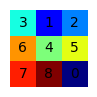

- Estado_objetivo=((0, 1, 2), (3, 4, 5), (6, 7, 8))


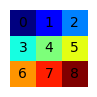

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h1
Seq = ['Left', 'Left', 'Up', 'Up']
Nodos visitados=5. Costo Solucion = 4
Voy a ejecutar la acción Left


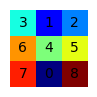

Voy a ejecutar la acción Left


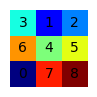

Voy a ejecutar la acción Up


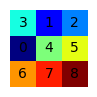

Voy a ejecutar la acción Up


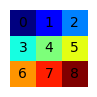

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

### Probando el entorno 8-puzzle y agente de búsqueda

Ejemplos de entornos de 8 puzzle: https://www.researchgate.net/figure/8-Puzzle-problem-instances_tbl1_280545587

In [ ]:
"""Crea el entorno del 8-puzzle con estado inicial '' """ # 10 movimientos
initial =  convert_tuple((1,6,2,5,7,3,0,4,8))
goal    =  convert_tuple((1,2,3,4,5,6,7,8,0))

In [ ]:
"""Crea el entorno del 8-puzzle con estado inicial '' """ # 30 movimientos
initial =  convert_tuple((1,2,3,8,0,4,7,6,5))
goal    =  convert_tuple((5,6,7,4,0,8,3,2,1))

#### busqueda

In [ ]:
e = EightpuzzleEnvironment(initial)

In [ ]:
"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h1') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((1, 2, 3), (8, 0, 4), (7, 6, 5))


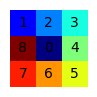

- Estado_objetivo=((5, 6, 7), (4, 0, 8), (3, 2, 1))


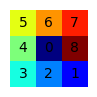

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h1
Seq = ['Down', 'Left', 'Up', 'Up', 'Right', 'Right', 'Down', 'Down', 'Left', 'Left', 'Up', 'Up', 'Right', 'Right', 'Down', 'Down', 'Left', 'Left', 'Up', 'Up', 'Right', 'Right', 'Down', 'Down', 'Left', 'Left', 'Up', 'Up', 'Right', 'Down']
Nodos visitados=119639. Costo Solucion = 30
Voy a ejecutar la acción Down


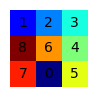

Voy a ejecutar la acción Left


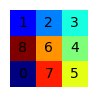

Voy a ejecutar la acción Up


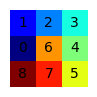

Voy a ejecutar la acción Up


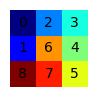

Voy a ejecutar la acción Right


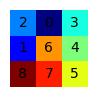

Voy a ejecutar la acción Right


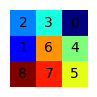

Voy a ejecutar la acción Down


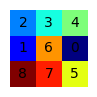

Voy a ejecutar la acción Down


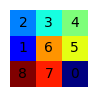

Voy a ejecutar la acción Left


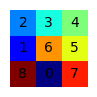

Voy a ejecutar la acción Left


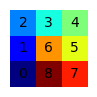

Voy a ejecutar la acción Up


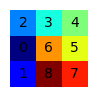

Voy a ejecutar la acción Up


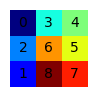

Voy a ejecutar la acción Right


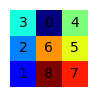

Voy a ejecutar la acción Right


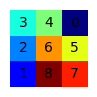

Voy a ejecutar la acción Down


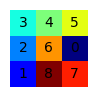

Voy a ejecutar la acción Down


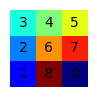

Voy a ejecutar la acción Left


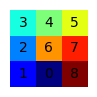

Voy a ejecutar la acción Left


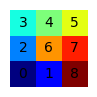

Voy a ejecutar la acción Up


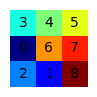

Voy a ejecutar la acción Up


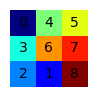

Voy a ejecutar la acción Right


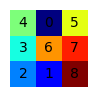

Voy a ejecutar la acción Right


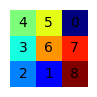

Voy a ejecutar la acción Down


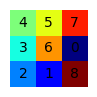

Voy a ejecutar la acción Down


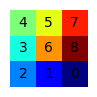

Voy a ejecutar la acción Left


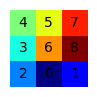

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

#### busqueda A* con heurística h2

In [ ]:
"""Inicializamos el entorno"""
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h2') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((1, 2, 3), (8, 0, 4), (7, 6, 5))


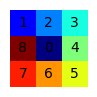

- Estado_objetivo=((5, 6, 7), (4, 0, 8), (3, 2, 1))


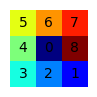

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h2
Seq = ['Down', 'Left', 'Up', 'Up', 'Right', 'Right', 'Down', 'Down', 'Left', 'Left', 'Up', 'Up', 'Right', 'Right', 'Down', 'Down', 'Left', 'Left', 'Up', 'Up', 'Right', 'Right', 'Down', 'Down', 'Left', 'Left', 'Up', 'Up', 'Right', 'Down']
Nodos visitados=2396. Costo Solucion = 30
Voy a ejecutar la acción Down


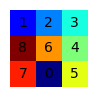

Voy a ejecutar la acción Left


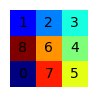

Voy a ejecutar la acción Up


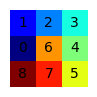

Voy a ejecutar la acción Up


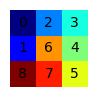

Voy a ejecutar la acción Right


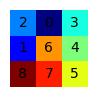

Voy a ejecutar la acción Right


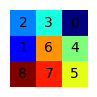

Voy a ejecutar la acción Down


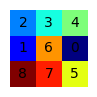

Voy a ejecutar la acción Down


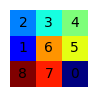

Voy a ejecutar la acción Left


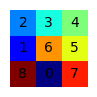

Voy a ejecutar la acción Left


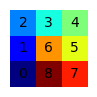

Voy a ejecutar la acción Up


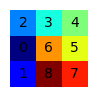

Voy a ejecutar la acción Up


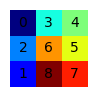

Voy a ejecutar la acción Right


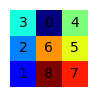

Voy a ejecutar la acción Right


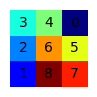

Voy a ejecutar la acción Down


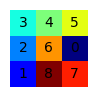

Voy a ejecutar la acción Down


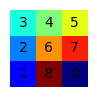

Voy a ejecutar la acción Left


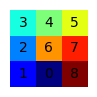

Voy a ejecutar la acción Left


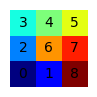

Voy a ejecutar la acción Up


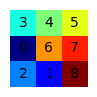

Voy a ejecutar la acción Up


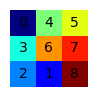

Voy a ejecutar la acción Right


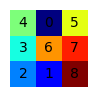

Voy a ejecutar la acción Right


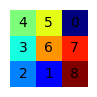

Voy a ejecutar la acción Down


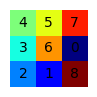

Voy a ejecutar la acción Down


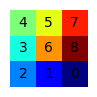

Voy a ejecutar la acción Left


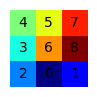

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

#### busqueda A* con heurística

In [ ]:
"""Inicializamos el entorno"""
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+hwei') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((1, 2, 3), (8, 0, 4), (7, 6, 5))


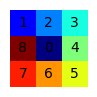

- Estado_objetivo=((5, 6, 7), (4, 0, 8), (3, 2, 1))


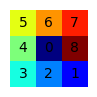

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+hwei
Seq = ['Left', 'Up', 'Right', 'Down', 'Left', 'Down', 'Right', 'Up', 'Right', 'Down', 'Left', 'Up', 'Right', 'Up', 'Left', 'Down', 'Left', 'Up', 'Right', 'Down', 'Right', 'Up', 'Left', 'Left', 'Down', 'Down', 'Right', 'Up', 'Left', 'Up', 'Right', 'Down', 'Left', 'Down', 'Right', 'Up']
Nodos visitados=28251. Costo Solucion = 36
Voy a ejecutar la acción Left


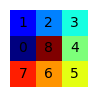

Voy a ejecutar la acción Up


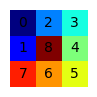

Voy a ejecutar la acción Right


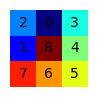

Voy a ejecutar la acción Down


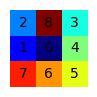

Voy a ejecutar la acción Left


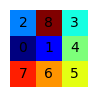

Voy a ejecutar la acción Down


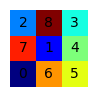

Voy a ejecutar la acción Right


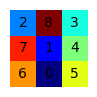

Voy a ejecutar la acción Up


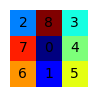

Voy a ejecutar la acción Right


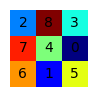

Voy a ejecutar la acción Down


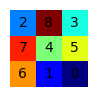

Voy a ejecutar la acción Left


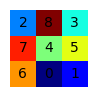

Voy a ejecutar la acción Up


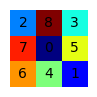

Voy a ejecutar la acción Right


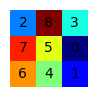

Voy a ejecutar la acción Up


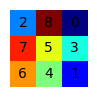

Voy a ejecutar la acción Left


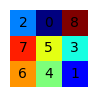

Voy a ejecutar la acción Down


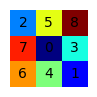

Voy a ejecutar la acción Left


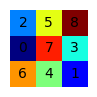

Voy a ejecutar la acción Up


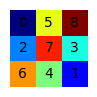

Voy a ejecutar la acción Right


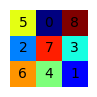

Voy a ejecutar la acción Down


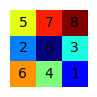

Voy a ejecutar la acción Right


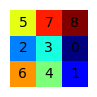

Voy a ejecutar la acción Up


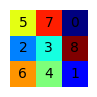

Voy a ejecutar la acción Left


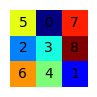

Voy a ejecutar la acción Left


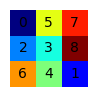

Voy a ejecutar la acción Down


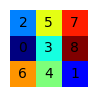

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

### Probando nuestro agente en un simulador online - Comparación de resultados

In [ ]:
"""Crea el entorno del 8-puzzle con estado inicial '' """
initial =  convert_tuple((3,1,2,6,4,5,7,8,0))
#goal    =  ((0,1,2),(3,4,5),(6,7,8)) # estado objetivo que teníamos previamente
goal    =  convert_tuple((1,2,3,4,5,6,7,8,0)) # para este estado inicial, este nuevo goal es más difícil

Veamos este simulador: https://deniz.co/8-puzzle-solver/

Nota: En este simulador, el estado objetivo es siempre: `((1, 2, 3), (4, 5, 6), (7, 8, 0))`.

Analicemos el árbol de búsqueda que genera! Qué pueden comentar al respecto?

Comparemos el costo de solución encontrado. Comparemos los valores que encuentra: costo de la solución encontrada y cantidad de nodos explorados. Son iguales? Son diferentes? Por que?

#### Spoiler




##### -

Observemos el orden de las acciones en el árbol de búsqueda. Es igual al nuestro? Veamos en más de un nodo.

#### Continuemos

In [ ]:
initial

((3, 1, 2), (6, 4, 5), (7, 8, 0))

#### busqueda en amplitud (BFS)

In [ ]:
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'bfs') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

In [ ]:
# Ejecuta el entorno 25 pasos
#e.run(25)

In [ ]:
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h2') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


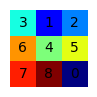

- Estado_objetivo=((1, 2, 3), (4, 5, 6), (7, 8, 0))


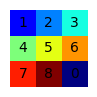

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h2
Seq = ['Left', 'Up', 'Left', 'Up', 'Right', 'Right', 'Down', 'Left', 'Left', 'Up', 'Right', 'Down', 'Down', 'Right', 'Up', 'Up', 'Left', 'Left', 'Down', 'Right', 'Right', 'Down']
Nodos visitados=1619. Costo Solucion = 22
Voy a ejecutar la acción Left


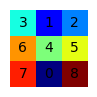

Voy a ejecutar la acción Up


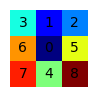

Voy a ejecutar la acción Left


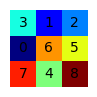

Voy a ejecutar la acción Up


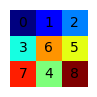

Voy a ejecutar la acción Right


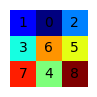

Voy a ejecutar la acción Right


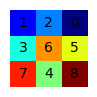

Voy a ejecutar la acción Down


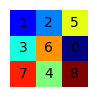

Voy a ejecutar la acción Left


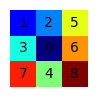

Voy a ejecutar la acción Left


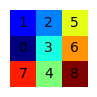

Voy a ejecutar la acción Up


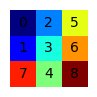

Voy a ejecutar la acción Right


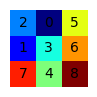

Voy a ejecutar la acción Down


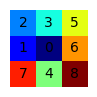

Voy a ejecutar la acción Down


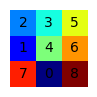

Voy a ejecutar la acción Right


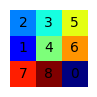

Voy a ejecutar la acción Up


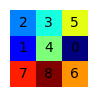

Voy a ejecutar la acción Up


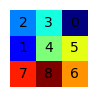

Voy a ejecutar la acción Left


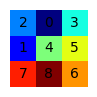

Voy a ejecutar la acción Left


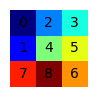

Voy a ejecutar la acción Down


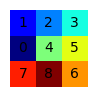

Voy a ejecutar la acción Right


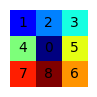

Voy a ejecutar la acción Right


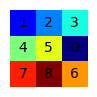

Voy a ejecutar la acción Down


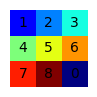

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)

#### busqueda A* con heurística h1

In [ ]:
"""Inicializamos el entorno"""
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h1') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


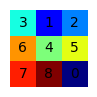

- Estado_objetivo=((1, 2, 3), (4, 5, 6), (7, 8, 0))


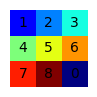

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h1
Seq = ['Left', 'Up', 'Left', 'Up', 'Right', 'Right', 'Down', 'Left', 'Left', 'Up', 'Right', 'Down', 'Down', 'Right', 'Up', 'Up', 'Left', 'Left', 'Down', 'Right', 'Right', 'Down']
Nodos visitados=6649. Costo Solucion = 22
Voy a ejecutar la acción Left


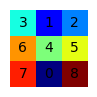

Voy a ejecutar la acción Up


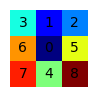

Voy a ejecutar la acción Left


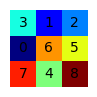

Voy a ejecutar la acción Up


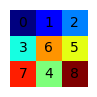

Voy a ejecutar la acción Right


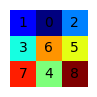

Voy a ejecutar la acción Right


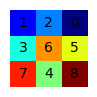

Voy a ejecutar la acción Down


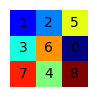

Voy a ejecutar la acción Left


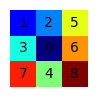

Voy a ejecutar la acción Left


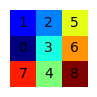

Voy a ejecutar la acción Up


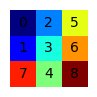

Voy a ejecutar la acción Right


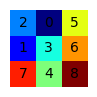

Voy a ejecutar la acción Down


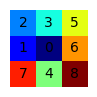

Voy a ejecutar la acción Down


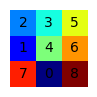

Voy a ejecutar la acción Right


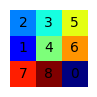

Voy a ejecutar la acción Up


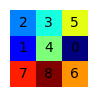

Voy a ejecutar la acción Up


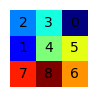

Voy a ejecutar la acción Left


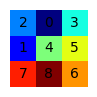

Voy a ejecutar la acción Left


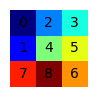

Voy a ejecutar la acción Down


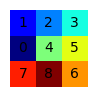

Voy a ejecutar la acción Right


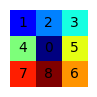

Voy a ejecutar la acción Right


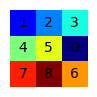

Voy a ejecutar la acción Down


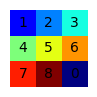

In [ ]:
# Ejecuta el entorno 25 pasos #312645780
e.run(25)

#### busqueda A* con heurística h2

In [ ]:
"""Inicializamos el entorno"""
e = EightpuzzleEnvironment(initial)

"""Crea un agente de busqueda para alcanzar goalstate"""
a = Agent( EightpuzzleSearchProgram(goal,'Astar+h2') )

"""Añade el agente creado al entorno"""
e.add_thing(a)

Agente buscara solucion al 8-puzzle

- Estado_inicial = ((3, 1, 2), (6, 4, 5), (7, 8, 0))


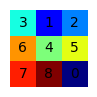

- Estado_objetivo=((1, 2, 3), (4, 5, 6), (7, 8, 0))


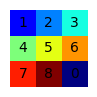

------------------------------
Agente planeó una solucion al 8-puzzle con Astar+h2
Seq = ['Left', 'Up', 'Left', 'Up', 'Right', 'Right', 'Down', 'Left', 'Left', 'Up', 'Right', 'Down', 'Down', 'Right', 'Up', 'Up', 'Left', 'Left', 'Down', 'Right', 'Right', 'Down']
Nodos visitados=1619. Costo Solucion = 22
Voy a ejecutar la acción Left


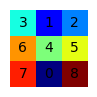

Voy a ejecutar la acción Up


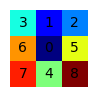

Voy a ejecutar la acción Left


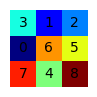

Voy a ejecutar la acción Up


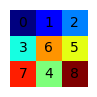

Voy a ejecutar la acción Right


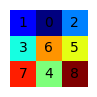

Voy a ejecutar la acción Right


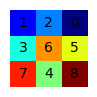

Voy a ejecutar la acción Down


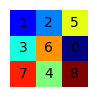

Voy a ejecutar la acción Left


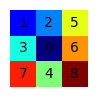

Voy a ejecutar la acción Left


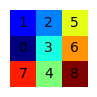

Voy a ejecutar la acción Up


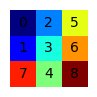

Voy a ejecutar la acción Right


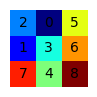

Voy a ejecutar la acción Down


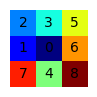

Voy a ejecutar la acción Down


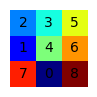

Voy a ejecutar la acción Right


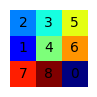

Voy a ejecutar la acción Up


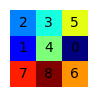

Voy a ejecutar la acción Up


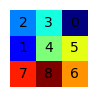

Voy a ejecutar la acción Left


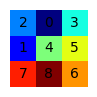

Voy a ejecutar la acción Left


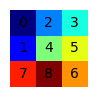

Voy a ejecutar la acción Down


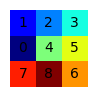

Voy a ejecutar la acción Right


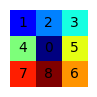

Voy a ejecutar la acción Right


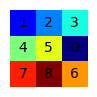

Voy a ejecutar la acción Down


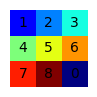

In [ ]:
# Ejecuta el entorno 25 pasos
e.run(25)